In [39]:
%load_ext autoreload
%autoreload 2

import jax
import jax.random as random
import jax.numpy as jnp

import numpy as np

import ott
from ott.tools import transport

from target_new import *

from plot import Plot

import matplotlib.pyplot as plt

print(f"JAX backend: {jax.default_backend()}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
JAX backend: cpu


In [2]:
rngs = jax.random.split(jax.random.PRNGKey(0),4)
n, m, d = 12, 14, 20
x = jax.random.normal(rngs[0], (n,d)) + 1
y = jax.random.uniform(rngs[1], (m,d))
a = jax.random.uniform(rngs[2], (n,))
b = jax.random.uniform(rngs[3], (m,))
a, b = a / jnp.sum(a), b / jnp.sum(b)
# Computes the couplings via Sinkhorn algorithm.
ot = transport.solve(x, y, a=a, b=b)
P = ot.matrix

#plott = Plot()
#_ = plott(ot)


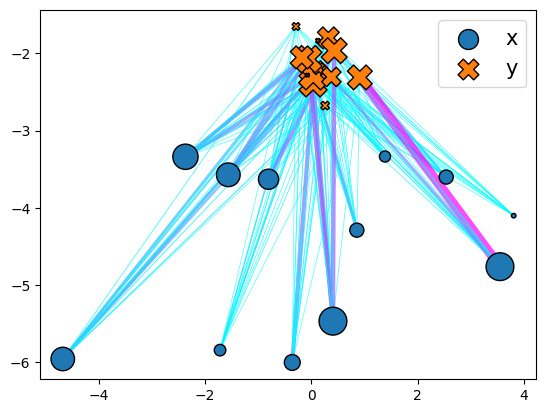

In [3]:
plott = Plot()
_ = plott(ot)

In [3]:
 '''
 from linearGaussian_new import LinearGaussian
 key = random.PRNGKey(123)
 key, subk = random.split(key)
 g_gt = ErdosReniDAGDistribution(n_vars = 20).sample_G(key = subk, return_mat=False)
 theta = LinearGaussian(graph_dist = ErdosReniDAGDistribution(
            n_vars=20, 
            n_edges_per_node=2),mean_edge= 10).sample_parameters(key=subk, n_vars = 20)
'''

In [3]:
'''
key = random.PRNGKey(123)
key, subk = random.split(key)
data, model = make_linear_gaussian_model(key=subk, n_vars=20, graph_prior_str="er")
'''

In [13]:
#dir(data)

In [19]:
#Sampling of 100 samples with the new procedure, for 2 time points
n_timepoints = 2
observations = []
for timepoint in range(n_timepoints):
    key = random.PRNGKey((timepoint+1)*100)
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=20, graph_prior_str="er",mean_edge=10.0,n_observations=10)
    observations.append(data.x)
observations

#No groups or patterns to be seen, everything is very random

[DeviceArray([[-5.96533279e+01,  6.60546265e+01,  6.07149109e+02,
                8.20736027e+00,  5.42745972e+00,  1.01821804e+01,
               -3.72895217e+00,  2.20059067e-01, -4.79089797e-01,
               -4.88123226e+00,  2.46217608e-01,  7.56365234e+03,
                5.57943506e+03, -5.29572535e+00,  4.22759342e+00,
                6.51201270e+03,  5.19423559e-02,  4.07200217e-01,
                4.62559938e-01,  7.33018982e+02],
              [ 3.96708822e+00, -5.13474178e+00, -6.06383018e+01,
               -6.78989697e+00, -7.63219893e-01, -7.25499916e+00,
                2.47304738e-01,  3.47147018e-01,  9.21119878e-04,
                6.95019215e-02,  6.91365451e-02, -6.22330322e+02,
               -6.22615845e+02,  2.34323442e-02,  4.98185730e+00,
               -6.28695435e+02,  9.57159773e-02,  1.91634655e-01,
               -8.96890834e-02, -4.75446053e+01],
              [-2.00327473e+01, -1.85336781e+01, -2.30446136e+02,
               -3.96595078e+01, -1.6067578

In [22]:
observations[0].shape

(10, 20)

## Sample parameters with different mean and standard deviation. 
#### 2 cases: 
- case 1: 2 groups in t1 with means -100 and 10 which move to 2 groups in t2 with means -200 and 10 
- case 2: 2 groups in t1 with means -10 and 10 which move to 3 groups in t2 with means -20, 5 and 15 


### I will try only changing the parameters of the theta distributions and changing the parameters of general sampling

In [41]:
# Here case 1 with 2-d examples 
key = random.PRNGKey(123)
key, subk = random.split(key)
observations1 = jnp.empty(shape=(0, 2), dtype='float32')
thetas1 = []
for mean_edge in [-100, 10]:
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=2, graph_prior_str="er",mean_edge=mean_edge,n_observations=50)
    observations1 = jnp.concatenate([observations1,data.x])
    thetas1.extend(data.theta)

Text(0.5, 1.0, 'Distribution with different thetas')

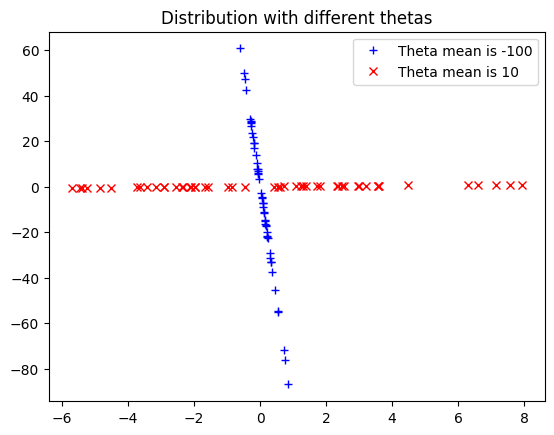

In [42]:
plt.figure(1)
plt.plot(observations1[0:50, 0], observations1[0:50, 1], '+b', label='Theta mean is -100')
plt.plot(observations1[50:, 0], observations1[50:, 1], 'xr', label='Theta mean is 10')
plt.legend(loc=0)
plt.title('Distribution with different thetas')

In [43]:
key = random.PRNGKey(124)
key, subk = random.split(key)
observations2 = jnp.empty(shape=(0, 2), dtype='float32')
thetas2 = []
for mean_edge in [ -200, 10]:
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=2, graph_prior_str="er",mean_edge=mean_edge,n_observations=50)
    observations2 = jnp.concatenate([observations2,data.x])
    thetas2.extend(data.theta)

Text(0.5, 1.0, 'Distribution with different thetas')

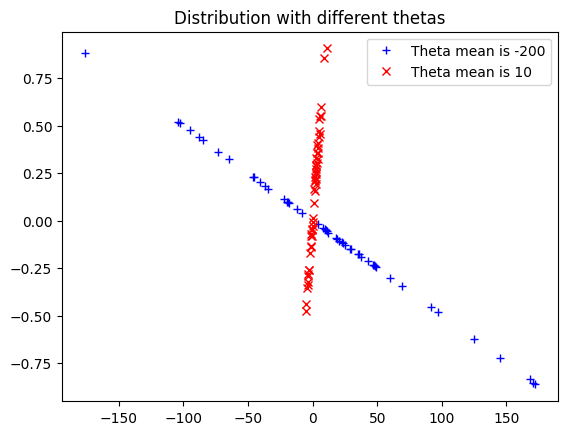

In [44]:
plt.plot(observations2[0:50, 0], observations2[0:50, 1], '+b', label='Theta mean is -200')
plt.plot(observations2[50:, 0], observations2[50:, 1], 'xr', label='Theta mean is 10')
plt.legend(loc=0)
plt.title('Distribution with different thetas')

In [45]:
# Samples two point clouds and their weights.
### For our synthetic data calculate the transport matrix
rngs = jax.random.split(jax.random.PRNGKey(0),2)
x1 = observations1
x2 = observations2
a = jax.random.uniform(rngs[0], (100,))
b = jax.random.uniform(rngs[1], (100,))
a, b = a / jnp.sum(a), b / jnp.sum(b)

# Computes the couplings via Sinkhorn algorithm.
ot = transport.solve(x1, x2, a=a, b=b)
# For adjacent time points we want to calculate the transport matrix (transport map) πti,ti+1
P = ot.matrix

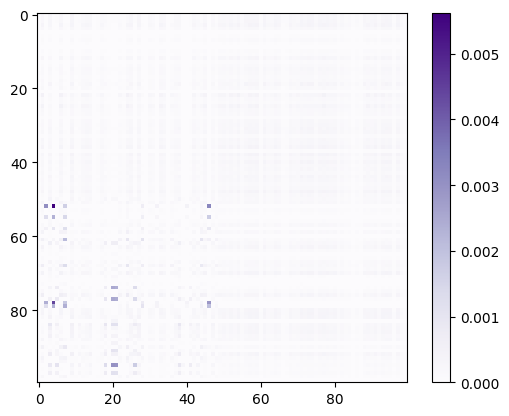

In [46]:
plt.imshow(P, cmap="Purples")
plt.colorbar()

#### Here I also change the parameters of sampling observations: 

##### In this way the samples will be more distinct

In [66]:
# Here case 1 with 2-d examples 
key = random.PRNGKey(123)
key, subk = random.split(key)
observations1 = jnp.empty(shape=(0, 2), dtype='float32')
thetas1 = []
mean_distributions = [-1, 1]
for i , mean_edge in enumerate([-10, 10]):
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=2, graph_prior_str="er",mean_edge=mean_edge,n_observations=50, mean_distr = mean_distributions[i])
    observations1 = jnp.concatenate([observations1,data.x])
    thetas1.extend(data.theta)

Text(0.5, 1.0, 'Distribution with different thetas')

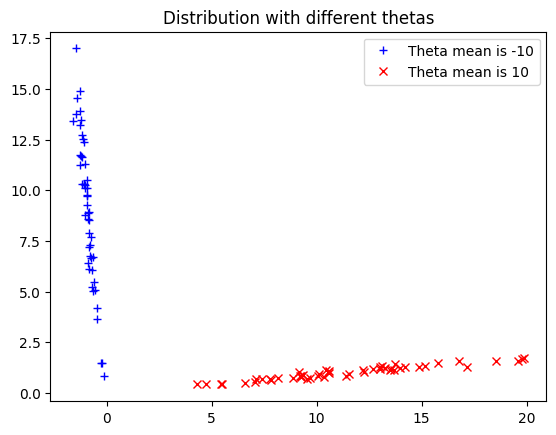

In [70]:
plt.figure(1)
plt.plot(observations1[0:50, 0], observations1[0:50, 1], '+b', label='Theta mean is -10')
plt.plot(observations1[50:, 0], observations1[50:, 1], 'xr', label='Theta mean is 10')
plt.legend(loc=0)
plt.title('Distribution with different thetas')

In [68]:
key = random.PRNGKey(124)
key, subk = random.split(key)
observations2 = jnp.empty(shape=(0, 2), dtype='float32')
thetas2 = []
mean_distributions = [-1, 1]
for i, mean_edge in enumerate([ -20, 10]):
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=2, graph_prior_str="er",mean_edge=mean_edge,n_observations=50, mean_distr = mean_distributions[i])
    observations2 = jnp.concatenate([observations2,data.x])
    thetas2.extend(data.theta)

In [74]:
thetas2[8].mean()

DeviceArray(-19.533146, dtype=float32)

Text(0.5, 1.0, 'Distribution with different thetas')

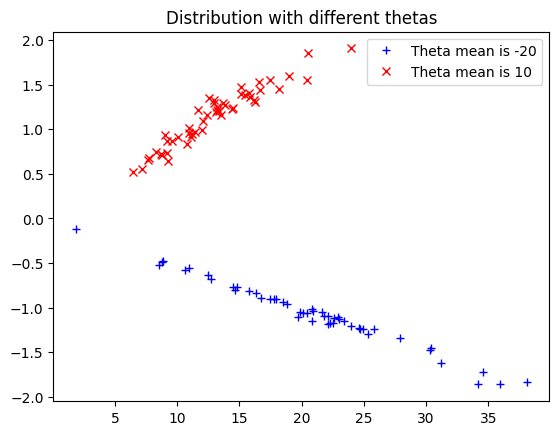

In [71]:
plt.plot(observations2[0:50, 0], observations2[0:50, 1], '+b', label='Theta mean is -20')
plt.plot(observations2[50:, 0], observations2[50:, 1], 'xr', label='Theta mean is 10')
plt.legend(loc=0)
plt.title('Distribution with different thetas')

In [36]:
# Samples two point clouds and their weights.
### For our synthetic data calculate the transport matrix
rngs = jax.random.split(jax.random.PRNGKey(0),2)
x1 = observations1
x2 = observations2
a = jax.random.uniform(rngs[0], (100,))
b = jax.random.uniform(rngs[1], (100,))
a, b = a / jnp.sum(a), b / jnp.sum(b)

# Computes the couplings via Sinkhorn algorithm.
ot = transport.solve(x1, x2, a=a, b=b)
# For adjacent time points we want to calculate the transport matrix (transport map) πti,ti+1
P = ot.matrix

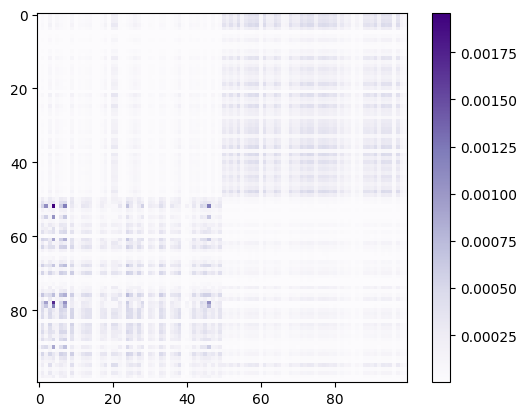

In [37]:
plt.imshow(P, cmap="Purples")
plt.colorbar()

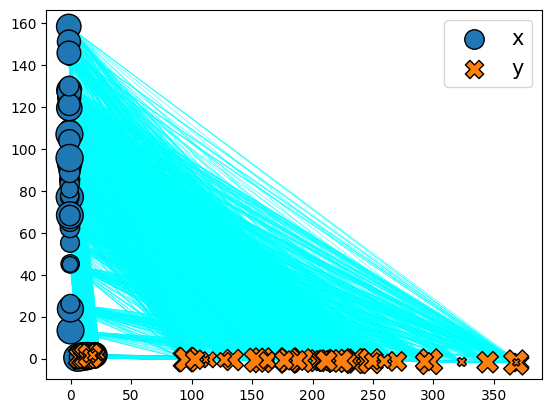

In [38]:
plott = ott.tools.plot.Plot()
_ = plott(ot)

#show_lines = False

In [61]:
# Here case 1 with 20-d example 
key = random.PRNGKey(123)
key, subk = random.split(key)
observations1 = jnp.empty(shape=(0,20), dtype='float32')
thetas1 = []
for mean_edge in [-10, 10]:
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=20, graph_prior_str="er",mean_edge=mean_edge,n_observations=50)
    observations1 = jnp.concatenate([observations1,data.x])
    thetas1.extend(data.theta)

In [62]:
key = random.PRNGKey(124)
key, subk = random.split(key)
observations2 = jnp.empty(shape=(0, 20), dtype='float32')
thetas2 = []
for mean_edge in [-20, 10]:
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=20, graph_prior_str="er",mean_edge=mean_edge,n_observations=50)
    observations2 = jnp.concatenate([observations2,data.x])
    thetas2.extend(data.theta)

### Try an optimal transport example:

In [63]:
# Samples two point clouds and their weights.
### For our synthetic data calculate the transport matrix
rngs = jax.random.split(jax.random.PRNGKey(0),2)
x1 = observations1
x2 = observations2
a = jax.random.uniform(rngs[0], (100,))
b = jax.random.uniform(rngs[1], (100,))
a, b = a / jnp.sum(a), b / jnp.sum(b)

# Computes the couplings via Sinkhorn algorithm.
ot = transport.solve(np.array(x1), np.array(x2), a=a, b=b)
# For adjacent time points we want to calculate the transport matrix (transport map) πti,ti+1
P = ot.matrix

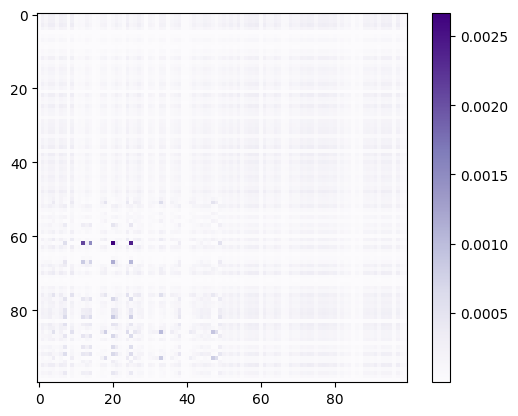

In [64]:
plt.imshow(P, cmap="Purples")
plt.colorbar()

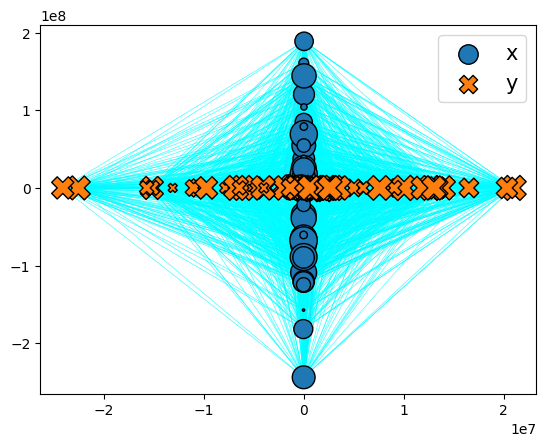

In [65]:
plott = Plot()
_ = plott(ot)

#### Here also change the parameters of observation distribution for high dim data:

In [57]:
# Here case 1 with 20-d example 
key = random.PRNGKey(123)
key, subk = random.split(key)
observations1 = jnp.empty(shape=(0,20), dtype='float32')
thetas1 = []
mean_distributions = [-1,1]
for i, mean_edge in enumerate([-10, 10]):
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=20, graph_prior_str="er",mean_edge=mean_edge,n_observations=50, mean_distr= mean_distributions[i])
    observations1 = jnp.concatenate([observations1,data.x])
    thetas1.extend(data.theta)

In [58]:
key = random.PRNGKey(124)
key, subk = random.split(key)
observations2 = jnp.empty(shape=(0, 20), dtype='float32')
thetas2 = []
mean_distributions = [-1,1]
for i, mean_edge in enumerate([-20, 10]):
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=20, graph_prior_str="er",mean_edge=mean_edge,n_observations=50, mean_distr = mean_distributions[i])
    observations2 = jnp.concatenate([observations2,data.x])
    thetas2.extend(data.theta)

In [59]:
rngs = jax.random.split(jax.random.PRNGKey(0),2)
x1 = observations1
x2 = observations2
a = jax.random.uniform(rngs[0], (100,))
b = jax.random.uniform(rngs[1], (100,))
a, b = a / jnp.sum(a), b / jnp.sum(b)

# Computes the couplings via Sinkhorn algorithm.
ot = transport.solve(np.array(x1), np.array(x2), a=a, b=b)
# For adjacent time points we want to calculate the transport matrix (transport map) πti,ti+1
P = ot.matrix

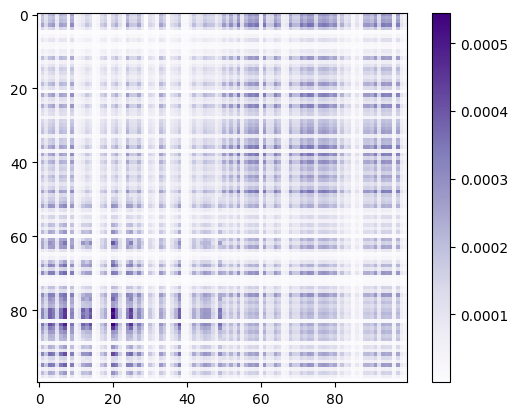

In [60]:
plt.imshow(P, cmap="Purples")
plt.colorbar()

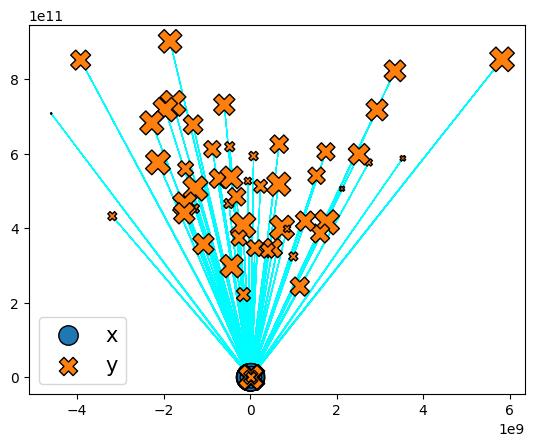

In [56]:
plott = Plot()
_ = plott(ot)

In [51]:
import numpy as np
import scipy
def bidimensional(x: jnp.ndarray, y: jnp.ndarray):
  """Apply PCA to reduce to bimensional data."""
  if x.shape[1] < 3:
    return x, y

  u, s, _ = scipy.sparse.linalg.svds(np.concatenate([x, y], axis=0), k=2)
  proj = u * s
  k = x.shape[0]
  return proj[:k], proj[k:]

In [56]:
scipy.sparse.linalg.svds(np.array(x1), k=2)

(array([[ 1.98777750e-01, -7.52441734e-02],
        [ 6.21073917e-02, -3.59168947e-02],
        [ 5.22697307e-02,  3.85414094e-01],
        [-1.01873845e-01, -1.22567825e-01],
        [ 1.54974103e-01,  7.53344372e-02],
        [-3.71675402e-01,  2.98245132e-01],
        [ 4.70243767e-03, -1.17715923e-02],
        [ 2.90277809e-01, -1.32392079e-01],
        [ 9.27379727e-02, -1.57079443e-01],
        [ 5.48323505e-02,  1.01788223e-01],
        [-1.38255386e-02, -2.46560704e-02],
        [-6.00565448e-02, -4.52178270e-02],
        [-1.31476775e-01,  9.25821289e-02],
        [-1.73036098e-01, -1.12612367e-01],
        [ 1.33868551e-03, -2.42555281e-03],
        [-2.00651288e-02, -1.73006609e-01],
        [-2.55864207e-03, -1.56717338e-02],
        [ 9.30791423e-02, -4.54323515e-02],
        [ 3.00642163e-01,  2.60010540e-01],
        [ 3.16314876e-01, -4.13543254e-01],
        [ 5.35854958e-02, -6.11908175e-02],
        [-3.09684426e-01, -2.71754682e-01],
        [ 3.82874832e-02, -4.533

In [41]:
type(x1)
#scipy.sparse.linalg.svds(np.concatenate([x1, x2], axis=0))

jaxlib.xla_extension.DeviceArray

In [52]:
bidimensional(x1, x2)

#x2.dtype

(array([[ 4.55067723e+13, -2.33013427e+09],
        [ 2.17220613e+13, -5.13450880e+08],
        [-2.33093395e+14,  1.14500168e+10],
        [ 7.41274362e+13, -3.65788365e+09],
        [-4.55612815e+13,  2.28380339e+09],
        [-1.80374735e+14,  9.02354227e+09],
        [ 7.11930518e+12, -3.57865952e+08],
        [ 8.00690117e+13, -4.01743181e+09],
        [ 9.49996015e+13, -4.68298854e+09],
        [-6.15601815e+13,  3.09019110e+09],
        [ 1.49116672e+13, -7.36560576e+08],
        [ 2.73471494e+13, -1.37794368e+09],
        [-5.59924652e+13,  2.77480704e+09],
        [ 6.81064876e+13, -3.32469760e+09],
        [ 1.46694288e+12, -7.35045680e+07],
        [ 1.04632139e+14, -5.18756864e+09],
        [ 9.47806064e+12, -4.70986240e+08],
        [ 2.74768960e+13, -1.39506598e+09],
        [-1.57250983e+14,  7.72907264e+09],
        [ 2.50105559e+14, -1.25558415e+10],
        [ 3.70074095e+13, -1.83763610e+09],
        [ 1.64353668e+14, -8.15284992e+09],
        [ 2.74208769e+13, -1.351

TypeError: type not understood

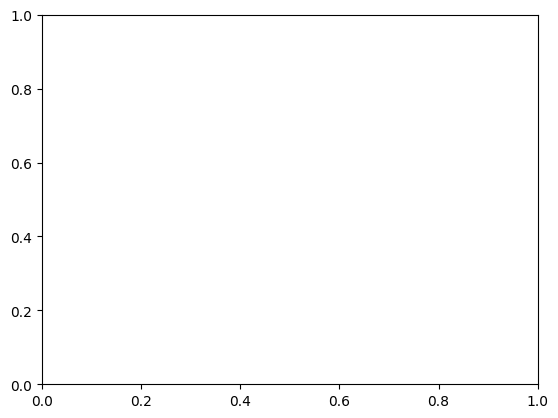

In [48]:
plott = ott.tools.plot.Plot()
_ = plott(ot)


In [64]:
P.shape # this matrix contains the couplings between the points

(100, 100)

The optimization problem that we want to solve is the following: 
$$\min_{i,j} \pi_{ij}c_{ij} \quad 

\text{s.t} \quad \pi \mathbb{1} = \alpha \quad  \text{and} \quad \pi^T \mathbb{1} = b $$


I could also use more advanced tools for calculating $\Pi$. See [here](https://ott-jax.readthedocs.io/en/stable/_autosummary/ott.core.sinkhorn.sinkhorn.html)

In [75]:
# Here case 2 with 2-d examples 
key = random.PRNGKey(123)
key, subk = random.split(key)
observations1 = jnp.empty(shape=(0, 2), dtype='float32')
thetas1 = []
for mean_edge in [-20,10]:
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=2, graph_prior_str="er",mean_edge=mean_edge,n_observations=15)
    observations1 = jnp.concatenate([observations1,data.x])
    thetas1.extend(data.theta)

Text(0.5, 1.0, 'Distribution with different thetas')

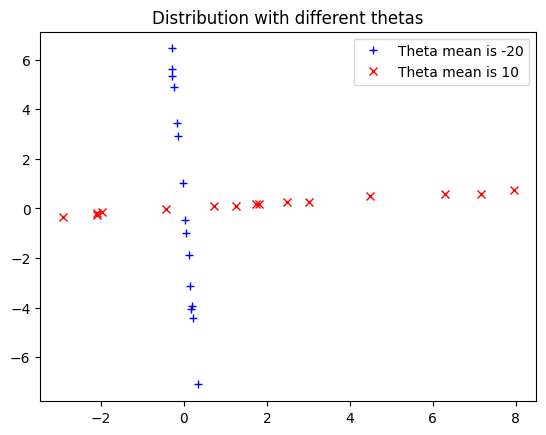

In [76]:
plt.figure(1)
plt.plot(observations1[0:15, 0], observations1[0:15, 1], '+b', label='Theta mean is -20')
plt.plot(observations1[15:, 0], observations1[15:, 1], 'xr', label='Theta mean is 10')
plt.legend(loc=0)
plt.title('Distribution with different thetas')

In [77]:
# Here case 2 with 2-d examples 
key = random.PRNGKey(123)
key, subk = random.split(key)
observations2 = jnp.empty(shape=(0, 2), dtype='float32')
thetas2 = []
for mean_edge in [-30,-10,10]:
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=2, graph_prior_str="er",mean_edge=mean_edge,n_observations=10)
    observations2 = jnp.concatenate([observations2,data.x])
    thetas2.extend(data.theta)

Text(0.5, 1.0, 'Distribution with different thetas')

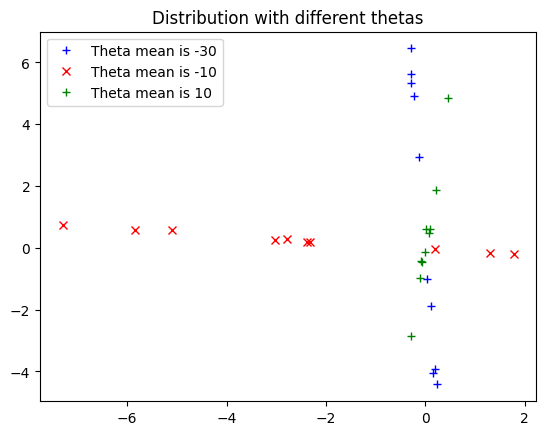

In [78]:
plt.figure(1)
plt.plot(observations2[0:10, 0], observations1[0:10, 1], '+b', label='Theta mean is -30')
plt.plot(observations2[10:20, 0], observations2[10:20, 1], 'xr', label='Theta mean is -10')
plt.plot(observations2[20:, 0], observations2[20:, 1], 'g+', label='Theta mean is 10')
plt.legend(loc=0)
plt.title('Distribution with different thetas')

In [79]:
# Samples two point clouds and their weights.
### For our synthetic data calculate the transport matrix
rngs = jax.random.split(jax.random.PRNGKey(0),2)
x1 = observations1
x2 = observations2
a = jax.random.uniform(rngs[0], (30,))
b = jax.random.uniform(rngs[1], (30,))
a, b = a / jnp.sum(a), b / jnp.sum(b)

# Computes the couplings via Sinkhorn algorithm.
ot = transport.solve(x1, x2, a=a, b=b)
# For adjacent time points we want to calculate the transport matrix (transport map) πti,ti+1
P = ot.matrix

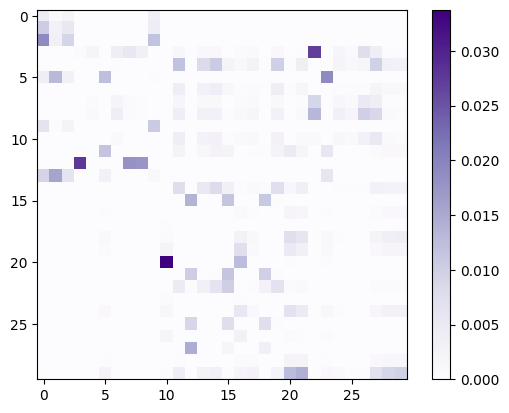

In [80]:
plt.imshow(P, cmap="Purples")
plt.colorbar()

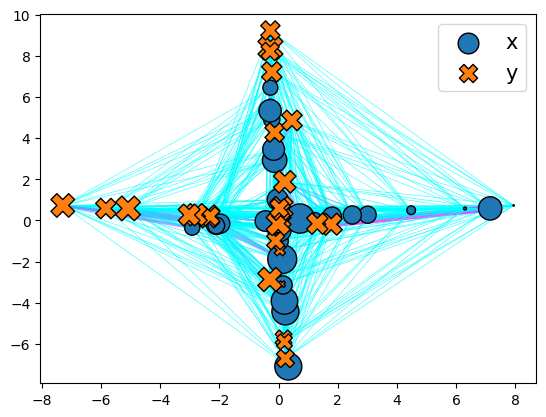

In [81]:
plott = ott.tools.plot.Plot()
_ = plott(ot)


#### Now try changing also the parameters of observation sampling distribution

In [82]:
key = random.PRNGKey(123)
key, subk = random.split(key)
observations1 = jnp.empty(shape=(0, 2), dtype='float32')
thetas1 = []
mean_distributions = [-1,1]
for i, mean_edge in enumerate([-20,10]):
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=2, graph_prior_str="er",mean_edge=mean_edge,n_observations=15, mean_distr=mean_distributions[i])
    observations1 = jnp.concatenate([observations1,data.x])
    thetas1.extend(data.theta)

Text(0.5, 1.0, 'Distribution with different thetas')

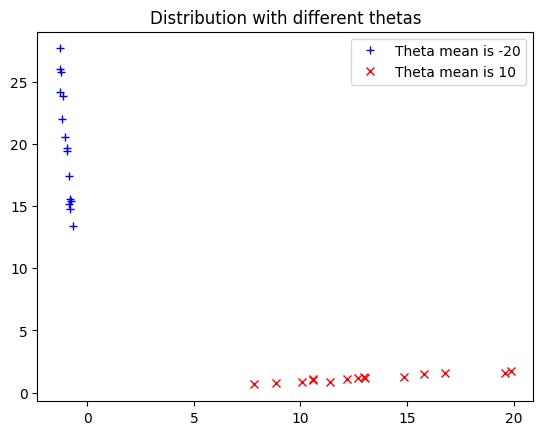

In [83]:
plt.figure(1)
plt.plot(observations1[0:15, 0], observations1[0:15, 1], '+b', label='Theta mean is -20')
plt.plot(observations1[15:, 0], observations1[15:, 1], 'xr', label='Theta mean is 10')
plt.legend(loc=0)
plt.title('Distribution with different thetas')

In [85]:
key = random.PRNGKey(123)
key, subk = random.split(key)
observations2 = jnp.empty(shape=(0, 2), dtype='float32')
thetas2 = []
mean_distributions = [-1,0,1]
for i, mean_edge in enumerate([-30,-10,10]):
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=2, graph_prior_str="er",mean_edge=mean_edge,n_observations=10, mean_distr= mean_distributions[i])
    observations2 = jnp.concatenate([observations2,data.x])
    thetas2.extend(data.theta)

Text(0.5, 1.0, 'Distribution with different thetas')

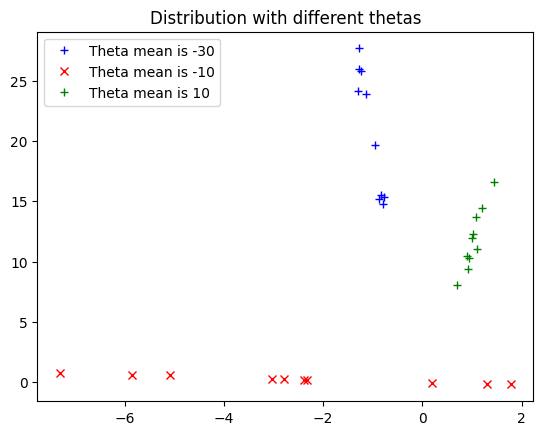

In [86]:
plt.figure(1)
plt.plot(observations2[0:10, 0], observations1[0:10, 1], '+b', label='Theta mean is -30')
plt.plot(observations2[10:20, 0], observations2[10:20, 1], 'xr', label='Theta mean is -10')
plt.plot(observations2[20:, 0], observations2[20:, 1], 'g+', label='Theta mean is 10')
plt.legend(loc=0)
plt.title('Distribution with different thetas')

In [87]:
# Samples two point clouds and their weights.
### For our synthetic data calculate the transport matrix
rngs = jax.random.split(jax.random.PRNGKey(0),2)
x1 = observations1
x2 = observations2
a = jax.random.uniform(rngs[0], (30,))
b = jax.random.uniform(rngs[1], (30,))
a, b = a / jnp.sum(a), b / jnp.sum(b)

# Computes the couplings via Sinkhorn algorithm.
ot = transport.solve(x1, x2, a=a, b=b)
# For adjacent time points we want to calculate the transport matrix (transport map) πti,ti+1
P = ot.matrix

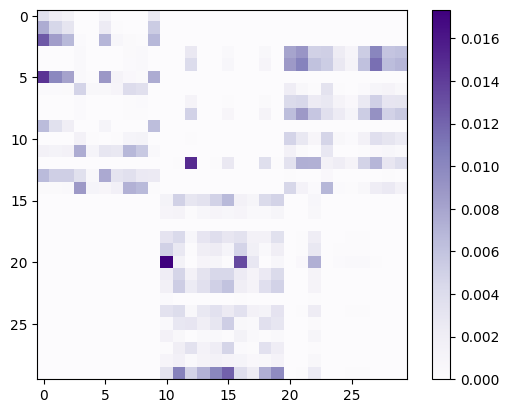

In [88]:
plt.imshow(P, cmap="Purples")
plt.colorbar()

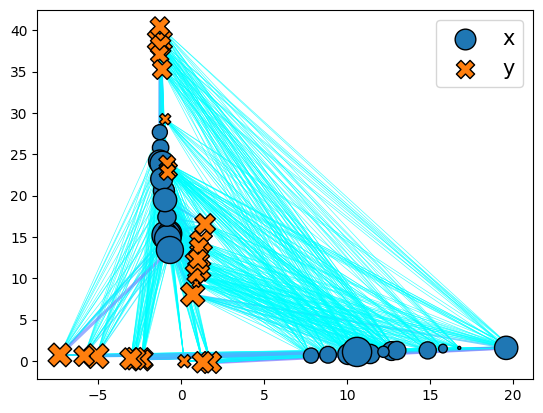

In [89]:
plott = ott.tools.plot.Plot()
_ = plott(ot)


#### Again here with 20d examples

In [90]:
# Here case 2 with 20-d examples 
key = random.PRNGKey(123)
key, subk = random.split(key)
observations1 = jnp.empty(shape=(0, 20), dtype='float32')
thetas1 = []
for mean_edge in [-20,10]:
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=20, graph_prior_str="er",mean_edge=mean_edge,n_observations=15)
    observations1 = jnp.concatenate([observations1,data.x])
    thetas1.extend(data.theta)

In [91]:
# Here case 2 with 20-d examples 
key = random.PRNGKey(123)
key, subk = random.split(key)
observations2 = jnp.empty(shape=(0, 20), dtype='float32')
thetas2 = []
for mean_edge in [-30,-10,10]:
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=20, graph_prior_str="er",mean_edge=mean_edge,n_observations=10)
    observations2 = jnp.concatenate([observations2,data.x])
    thetas2.extend(data.theta)

In [92]:
# Samples two point clouds and their weights.
### For our synthetic data calculate the transport matrix
rngs = jax.random.split(jax.random.PRNGKey(0),2)
x1 = observations1
x2 = observations2
a = jax.random.uniform(rngs[0], (30,))
b = jax.random.uniform(rngs[1], (30,))
a, b = a / jnp.sum(a), b / jnp.sum(b)

# Computes the couplings via Sinkhorn algorithm.
ot = transport.solve(x1, x2, a=a, b=b)
# For adjacent time points we want to calculate the transport matrix (transport map) πti,ti+1
P = ot.matrix

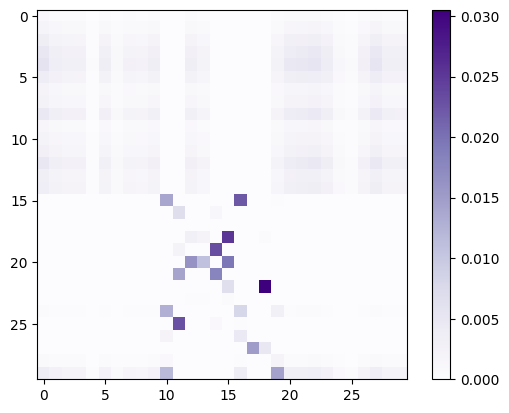

In [93]:
plt.imshow(P, cmap="Purples")
plt.colorbar()

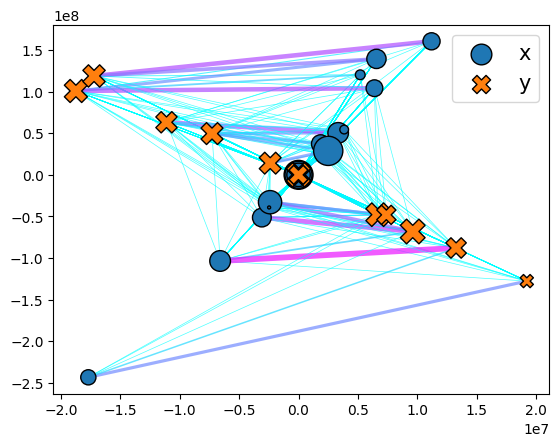

In [94]:
plott = Plot()
_ = plott(ot)

### Now try changing the observations distribution parameters also for the high dimensional setting:

In [95]:
key = random.PRNGKey(123)
key, subk = random.split(key)
observations1 = jnp.empty(shape=(0, 20), dtype='float32')
thetas1 = []
mean_distributions = [-1,1]
for i, mean_edge in enumerate([-20,10]):
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=20, graph_prior_str="er",mean_edge=mean_edge,n_observations=15, mean_distr=mean_distributions[i])
    observations1 = jnp.concatenate([observations1,data.x])
    thetas1.extend(data.theta)

In [96]:
key = random.PRNGKey(123)
key, subk = random.split(key)
observations2 = jnp.empty(shape=(0, 20), dtype='float32')
thetas2 = []
mean_distributions = [-1,0,1]
for mean_edge in [-30,-10,10]:
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=20, graph_prior_str="er",mean_edge=mean_edge,n_observations=10, mean_distr=mean_distributions[i])
    observations2 = jnp.concatenate([observations2,data.x])
    thetas2.extend(data.theta)

In [97]:
rngs = jax.random.split(jax.random.PRNGKey(0),2)
x1 = observations1
x2 = observations2
a = jax.random.uniform(rngs[0], (30,))
b = jax.random.uniform(rngs[1], (30,))
a, b = a / jnp.sum(a), b / jnp.sum(b)

# Computes the couplings via Sinkhorn algorithm.
ot = transport.solve(x1, x2, a=a, b=b)
# For adjacent time points we want to calculate the transport matrix (transport map) πti,ti+1
P = ot.matrix

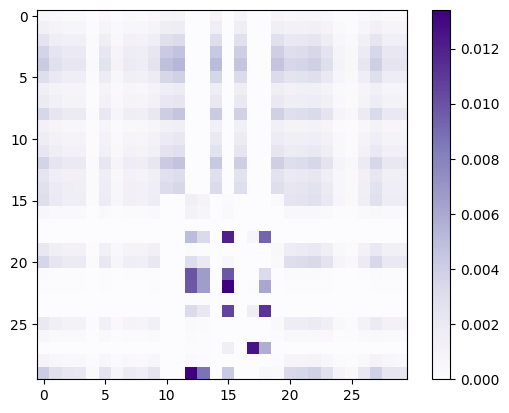

In [98]:
plt.imshow(P, cmap="Purples")
plt.colorbar()

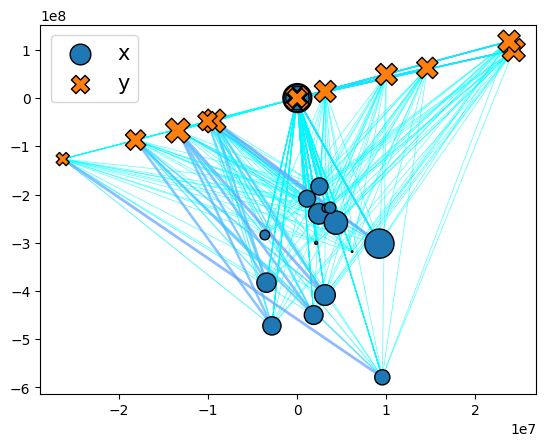

In [99]:
plott = Plot()
_ = plott(ot)

### The original example of the documentation:

In [127]:
rngs = jax.random.split(jax.random.PRNGKey(0),6)
n, m, d = 12, 14, 2
x1 = jax.random.normal(rngs[0], (n,d)) + 1 #here the mean is one
x2 = jax.random.normal(rngs[1], (n,d)) 
x = jnp.concatenate([x1,x2], axis=0)
y1 = jax.random.uniform(rngs[2], (m,d)) #here the mean is zero
y2 = jax.random.normal(rngs[3], (m,d)) + 1 
y = jnp.concatenate([y1,y2], axis=0)
a = jax.random.uniform(rngs[4], (2*n,))
b = jax.random.uniform(rngs[5], (2*m,))
a, b = a / jnp.sum(a), b / jnp.sum(b)
# Computes the couplings via Sinkhorn algorithm.
ot = transport.solve(x, y, a=a, b=b)
P = ot.matrix


In [44]:
y.shape

(28, 2)

Text(0.5, 1.0, 'the different points')

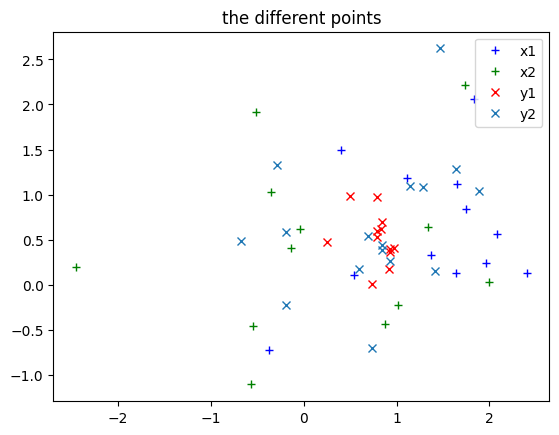

In [128]:
plt.figure(1)
plt.plot(x[0:12, 0], x[0:12, 1], '+b', label='x1')
plt.plot(x[12:, 0], x[12:, 1], '+g', label='x2')
plt.plot(y[0:12, 0], y[0:12, 1], 'xr', label='y1')
plt.plot(y[12:, 0], y[12:, 1], 'x', label='y2')
plt.legend(loc=0)
plt.title('the different points')
#we want to match the red with the blue

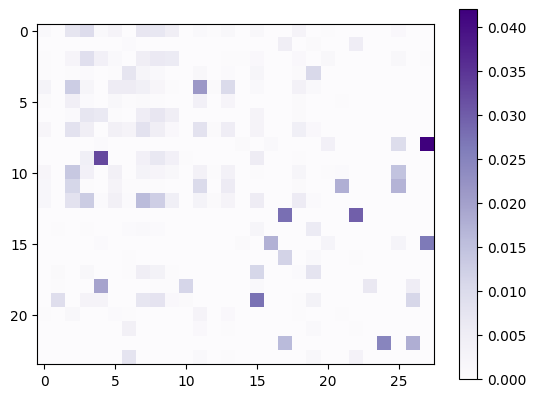

In [129]:
plt.imshow(P, cmap="Purples")
plt.colorbar()

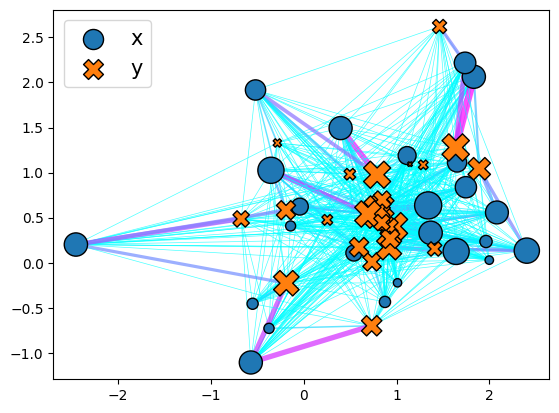

In [130]:
plott = ott.tools.plot.Plot()
_ = plott(ot)

In [51]:
seed = 1234
ss = np.random.SeedSequence(seed)

In [53]:
ss.spawn(2)

[SeedSequence(
     entropy=1234,
     spawn_key=(0,),
 ),
 SeedSequence(
     entropy=1234,
     spawn_key=(1,),
 )]

In [67]:
seed = 123
np.random.seed(seed)

In [70]:
np.random.randint(0,100, size=2)

array([83, 57])

In [66]:
np.random.randint(0,100, size=2)

array([83, 57])

In [73]:
key = random.PRNGKey(111)

subkeys = random.split(key, num=5)

In [76]:
subkeys

DeviceArray([[2149343144, 3788759061],
             [1263116805, 2203640444],
             [ 260051842, 2161001049],
             [ 450316230, 2080109636],
             [2532194002, 3516360950]], dtype=uint32)

In [83]:
# Passing the original key to a random function
random_integers = random.randint(key=key, minval=0, maxval=10, shape=[5])
print(random_integers)
print(key)

[0 1 3 7 8]
[  0 111]


In [87]:
subkey = random.split(key, num=5)

In [91]:
subkey[0]

DeviceArray([3180792733, 3041662802], dtype=uint32)

In [95]:
key = random.PRNGKey(1234)
for i in range(5):
    #key = random.PRNGKey(1234)
    print(f"Iteration: {i+1}\n")
    print(f"Original key: {key}")
    key, subkey = random.split(key)
    print(f"First subkey: {key}")
    print(f"Second subkey: {subkey}")
    print("="*50)
    print("")

Iteration: 1

Original key: [   0 1234]
First subkey: [2113592192 1902136347]
Second subkey: [603280156 445306386]

Iteration: 2

Original key: [2113592192 1902136347]
First subkey: [1076515368 3893328283]
Second subkey: [4074306999 1136378523]

Iteration: 3

Original key: [1076515368 3893328283]
First subkey: [2236037635 1430511502]
Second subkey: [3028232624  826525938]

Iteration: 4

Original key: [2236037635 1430511502]
First subkey: [2722901646 2546220691]
Second subkey: [1745697455 2437247537]

Iteration: 5

Original key: [2722901646 2546220691]
First subkey: [1310741317  140932042]
Second subkey: [ 578777548 1592809606]



In [98]:
key = random.PRNGKey(1234)
subkey = random.split(key, num = 5)
print(subkey)

[[3899778567 2534451897]
 [1317645257 3939813896]
 [3063296813 1232842604]
 [3005696263 2652472927]
 [2118949861 3484553493]]
